Found 320 files belonging to 4 classes.
Using 256 files for training.
Found 320 files belonging to 4 classes.
Using 64 files for validation.
Epoch 1/100
4/4 [==============================] - 8s 806ms/step - loss: 3.9111 - accuracy: 0.3164 - val_loss: 529091.1875 - val_accuracy: 0.2969
Epoch 2/100
4/4 [==============================] - 2s 532ms/step - loss: 1.3959 - accuracy: 0.4805 - val_loss: 2475795.5000 - val_accuracy: 0.2969
Epoch 3/100
4/4 [==============================] - 2s 531ms/step - loss: 1.2869 - accuracy: 0.5586 - val_loss: 10936140.0000 - val_accuracy: 0.2969
Epoch 4/100
4/4 [==============================] - 2s 532ms/step - loss: 0.9737 - accuracy: 0.6836 - val_loss: 5298417.5000 - val_accuracy: 0.2969
Epoch 5/100
4/4 [==============================] - 2s 536ms/step - loss: 0.6810 - accuracy: 0.7734 - val_loss: 2502692.0000 - val_accuracy: 0.2031
Epoch 6/100
4/4 [==============================] - 2s 534ms/step - loss: 0.6042 - accuracy: 0.7812 - val_loss: 1454235.2500 

<Figure size 720x720 with 0 Axes>

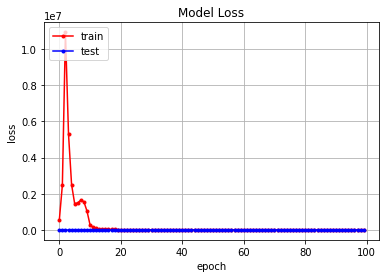

In [3]:
#ResNet

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from tensorflow import keras
from keras.layers import Input
from keras import Model


# load
# data_dir = './HW1-1_data'
data_dir = './images/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))



# train_data_dir = './Mura_dataset/mura/train'
# train_data_dir = pathlib.Path(train_data_dir)
# image_count_train = len(list(train_data_dir.glob('*/*.jpg')))

# test_data_dir = './Mura_dataset/mura/valid'
# test_data_dir = pathlib.Path(test_data_dir)
# image_count_test = len(list(test_data_dir.glob('*/*.jpg')))


# data prep
batch_size = 64
img_height = 256
img_width = 256
trainX = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
testX = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
classes = trainX.class_names
plt.figure(figsize=(10, 10))

# model
def ResNet():
  input_layer = Input(shape=(256, 256, 3))
  res = keras.layers.ZeroPadding2D(padding=3, name='padding_conv1')(input_layer)
  res = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name='conv1')(res)
  res = keras.layers.BatchNormalization(axis=3, epsilon=1e-5, name='bn_conv1')(res)
  res = keras.layers.Activation('relu', name='conv1_relu')(res)
  res = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(res)
  res = conv_block(res, 3, [256, 256, 256], stage=2, block='a', strides=(1, 1))
  res = identity_block(res, 3, [64, 64, 256], stage=2, block='b')
  res = identity_block(res, 3, [64, 64, 256], stage=2, block='c')
  res = conv_block(res, 3, [128, 128, 512], stage=3, block='a')
  res = identity_block(res, 3, [128, 128, 512], stage=3, block='b')
  res = identity_block(res, 3, [128, 128, 512], stage=3, block='c')
  res = identity_block(res, 3, [128, 128, 512], stage=3, block='d')
  res = conv_block(res, 3, [256, 256, 1024], stage=4, block='a') #1
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='b')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='c')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='d')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='e')
  res = identity_block(res, 3, [256, 256, 1024], stage=4, block='f')
  res = conv_block(res, 3, [512, 512, 2048], stage=5, block='a') #2
  res = identity_block(res, 3, [512, 512, 2048], stage=5, block='b')
  res = identity_block(res, 3, [512, 512, 2048], stage=5, block='c')
  res = keras.layers.GlobalAveragePooling2D(name='pool5')(res)
  res = keras.layers.Dense(4, activation='softmax', name='fc1000')(res)
  model = Model(input_layer, [res], name='ResNet')
  return model


def identity_block(input, kernel_size, filters, stage, block):
  filters1, filters2, filters3 = filters
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  IDconv = keras.layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
  IDbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(IDconv)
  IDactive = keras.layers.Activation('relu')(IDbatch)
  IDconv = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(IDactive)
  IDbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(IDconv)
  IDactive = keras.layers.Activation('relu')(IDbatch)
  IDconv = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(IDactive)
  IDbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(IDconv)
  IDlayer = keras.layers.add([IDbatch, input])
  identity = keras.layers.Activation('relu')(IDlayer)
  return identity

def conv_block(input, kernel_size, filters, stage, block, strides=(2, 2)):
  filters1, filters2, filters3 = filters
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  volconv = keras.layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
  volbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(volconv)
  volactive = keras.layers.Activation('relu')(volbatch)
  volconv = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(volactive)
  volbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(volconv)
  volactive = keras.layers.Activation('relu')(volbatch)
  volconv = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(volactive)
  volbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(volconv)
  shortcut = keras.layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input)
  shortcutbatch = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)
  output = keras.layers.add([volbatch, shortcutbatch])
  convolution = keras.layers.Activation('relu')(output)
  return convolution

model = ResNet()
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(trainX, validation_data=testX, epochs=100)

y_vloss = history.history['val_loss']
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']


fig, (ax1) = plt.subplots(1)
ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
ax1.grid()
plt.title('Model Loss')
plt.setp(ax1, xlabel='epoch', ylabel='loss')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./loss per epochs for ResNet-graph.jpg")
plt.show()

fig, (ax2) = plt.subplots(1)
ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
ax2.grid()
plt.title('Model Accuracy') 
plt.setp(ax2, xlabel='epoch', ylabel='accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("./accuracy per epochs for ResNet-graph.jpg")
plt.show()

# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
# ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
# ax1.grid()
# plt.setp(ax1, xlabel='epoch', ylabel='loss')

# ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
# ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
# ax2.grid()
# plt.setp(ax2, xlabel='epoch', ylabel='accuracy')

# plt.show()
